<a href="https://colab.research.google.com/github/mohamedghaly1/ECG-Detection-Using-EGRU/blob/main/Experiments%20EGRU%20models/Experiment_5_best_97_46_EGRU_ECG_ARRHYTHMIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone Repository and Setup Environment (EvNN)

In [ ]:
!git clone https://github.com/Efficient-Scalable-Machine-Learning/EvNN.git

Cloning into 'EvNN'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 116 (delta 39), reused 86 (delta 23), pack-reused 0
Receiving objects: 100% (116/116), 6.68 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [ ]:
%cd /content/EvNN

/content/EvNN


In [ ]:
# Set CUDA_HOME environment variable
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-10.2'  # Change the version if needed

In [ ]:
!make evnn_pytorch

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda-10.2'
running bdist_wheel
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:500: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
running build
running build_py
creating build/lib.linux-x86_64-cpython-310
creating build/lib.linux-x86_64-cpython-310/evnn_pytorch
copying frameworks/pytorch/_version.py -> build/lib.linux-x86_64-cpython-310/evnn_pytorch
copying frameworks/pytorch/base_rnn.py -> build/lib.linux-x86_64-cpython-310/evnn_pytorch
copying frameworks/pytorch/egru.py -> build/lib.linux-x86_64-cpython-310/evnn_pytorch
copying frameworks/pytorch/__init__.py -> build/lib.linux-x86_64-cpython-310/evnn_pytorch
running build_ext
make[1]: Entering directory '/tmp/tmp.Q9nfX9M8BZ'
g++  -c lib/egru_forward_cpu.cc -L. -lcblas -o lib/egru_forward_cpu.o  -fPIC -Ilib 

In [ ]:
!pip install evnn_pytorch-*.whl

Processing ./evnn_pytorch-0.1.0-cp310-cp310-linux_x86_64.whl


In [ ]:
!pip install eco2ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.4.0 requires pandas>=1.5.0, but you have pandas 1.4.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.4.3 which is incompatible.
plotnine 0.12.4 requires pandas>=1.5.0, but you have pandas 1.4.3 which is incompatible.


# Download and Extract Kaggle Dataset (MIT-BIH)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/kaggle_dataset'

In [ ]:
%cd /content/gdrive/MyDrive/kaggle_dataset/

In [ ]:
!ls

In [ ]:
!kaggle datasets download -d shayanfazeli/heartbeat

In [ ]:
!mkdir heartbeat
!mv heartbeat.zip heartbeat

In [ ]:
%cd heartbeat/

In [ ]:
!unzip heartbeat.zip

# Import libraries

In [ ]:
import torch
import evnn_pytorch as evnn
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

import eco2ai

# Load and Preprocess Data

Load Data

In [ ]:
train_df = pd.read_csv("/content/gdrive/MyDrive/kaggle_dataset/heartbeat/mitbih_train.csv",header=None)
test_df = pd.read_csv("/content/gdrive/MyDrive/kaggle_dataset/heartbeat/mitbih_test.csv",header=None)
print(train_df[187].value_counts())

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


Data Exploration and Visualization

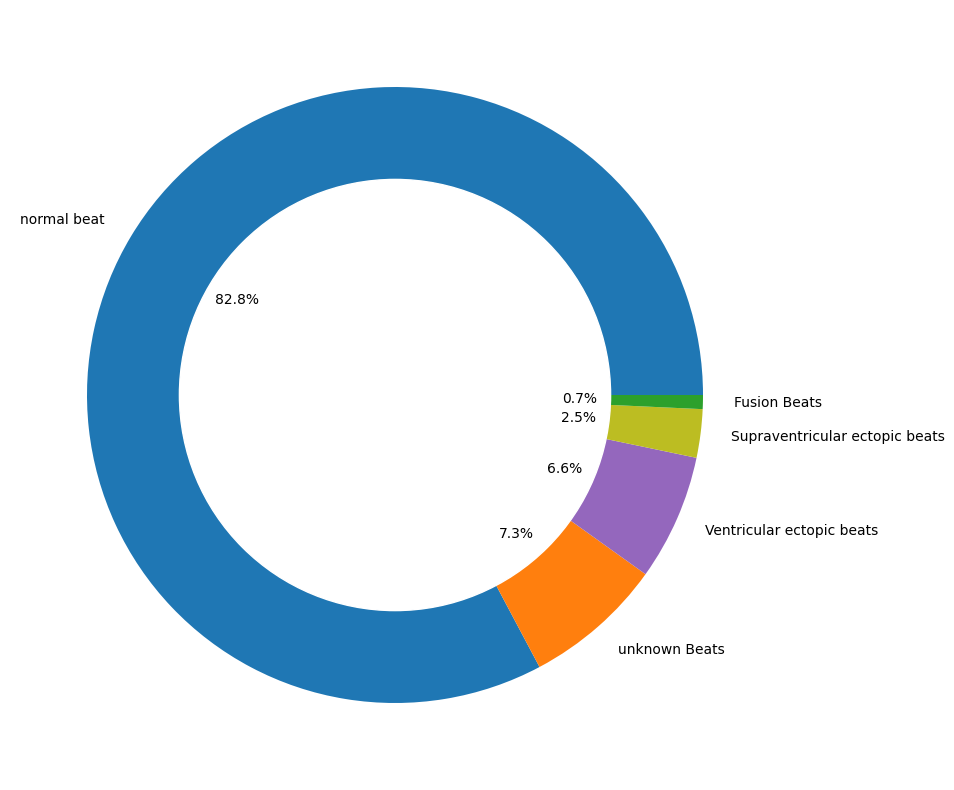

In [ ]:
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Class Balancing using SMOTE

In [ ]:
from sklearn.utils import resample
df_1=train_df [train_df [187]==1]
df_2=train_df [train_df [187]==2]
df_3=train_df [train_df[187]==3]
df_4=train_df [train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=65000,random_state=42)
train_df=pd.concat([df_0,df_1,df_2,df_3,df_4])

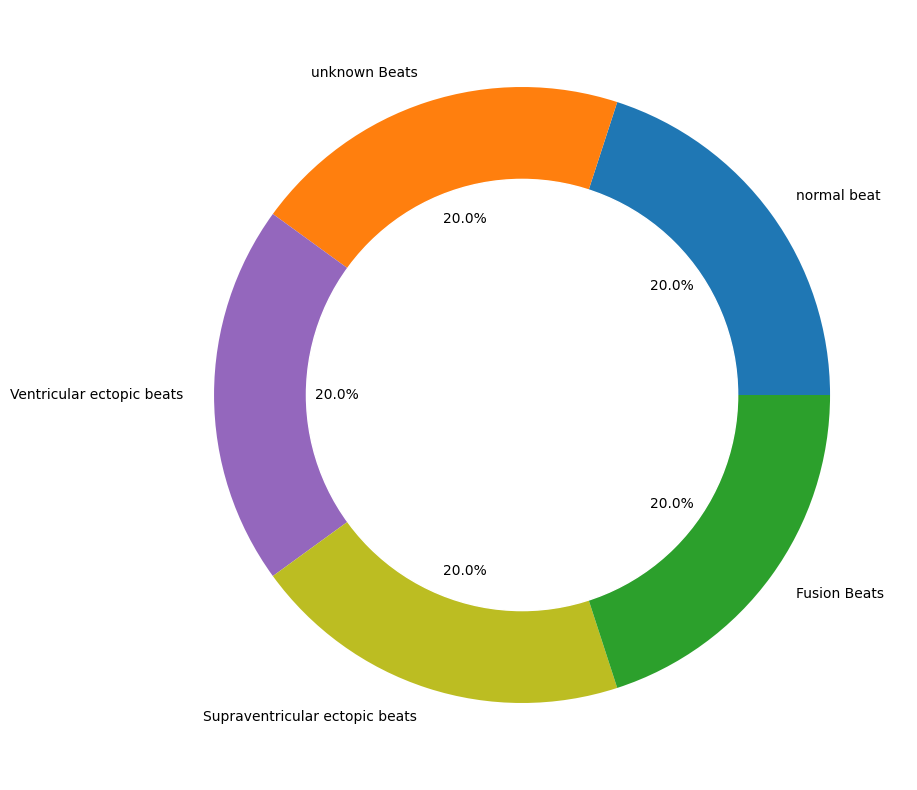

0.0    65000
1.0    65000
2.0    65000
3.0    65000
4.0    65000
Name: 187, dtype: int64


In [ ]:
# Separate features and target variable
X = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].values

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Concatenate the resampled data
train_df = pd.DataFrame(X_resampled)
train_df[187] = y_resampled

per_class = train_df[187].value_counts()
plt.figure(figsize=(20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat', 'unknown Beats', 'Ventricular ectopic beats', 'Supraventricular ectopic beats', 'Fusion Beats'], colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
print(train_df[187].value_counts())

Display Sample ECG Signals

In [ ]:
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
print("classes:",classes)

classes:              0         1         2         3         4         5         6    \
4293    0.957447  0.836879  0.432624  0.173759  0.056738  0.039007  0.024823   
88711   1.000000  0.878059  0.164097  0.000000  0.190285  0.240878  0.273521   
191544  0.000000  0.029313  0.104105  0.195453  0.275240  0.330240  0.373457   
214430  0.790300  1.000000  0.659119  0.327180  0.203357  0.197206  0.176731   
310438  0.762298  0.659303  0.542964  0.403201  0.267759  0.142360  0.058925   

             7         8         9    ...  178  179  180  181  182  183  184  \
4293    0.024823  0.014184  0.014184  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
88711   0.269341  0.268689  0.283247  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
191544  0.423070  0.438176  0.428629  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
214430  0.163188  0.159883  0.157455  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
310438  0.006391  0.008217  0.041577  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        185  186  187  
4293 

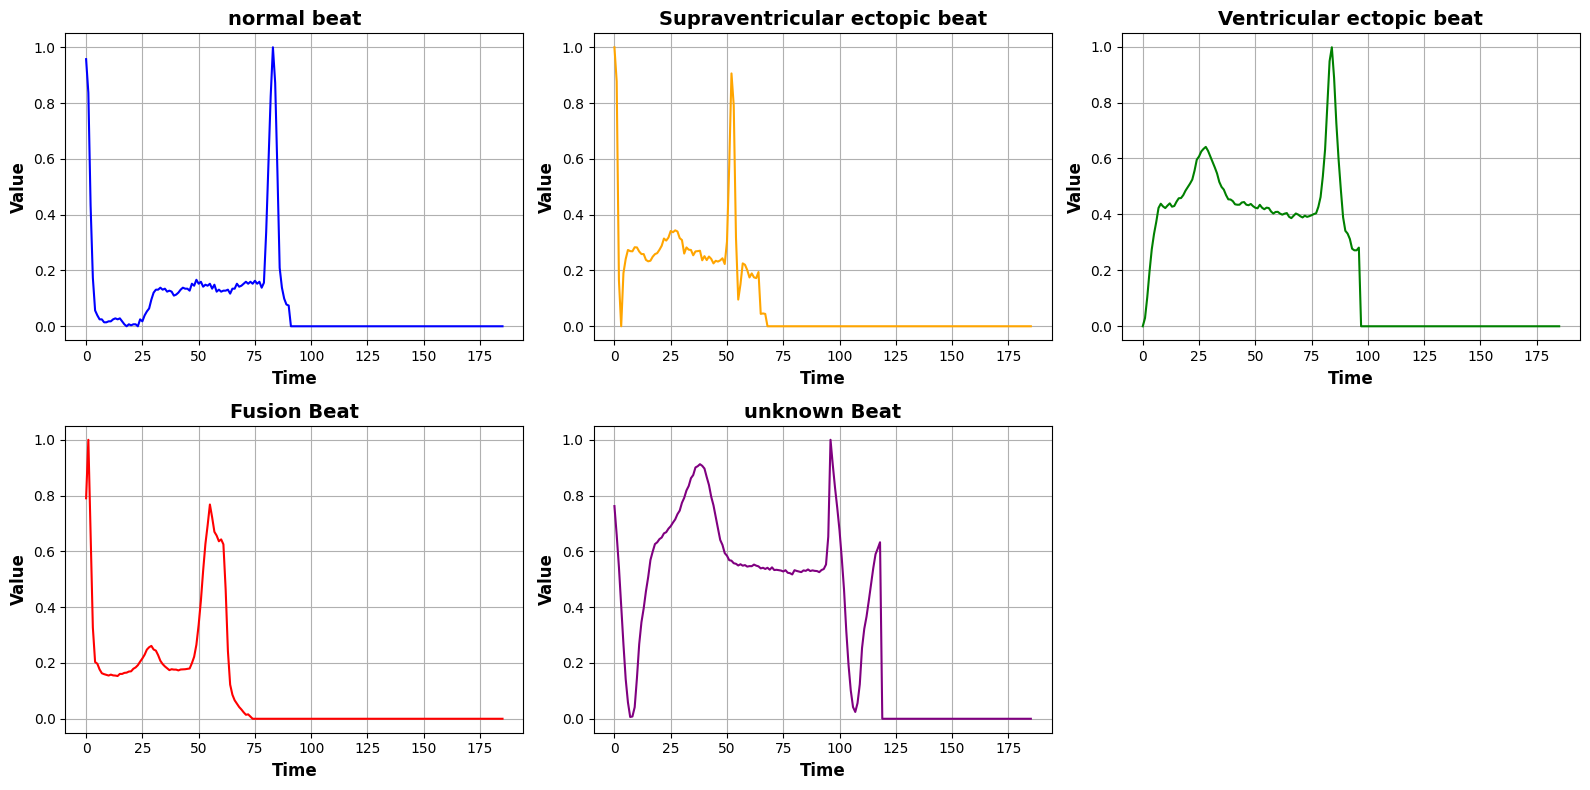

In [ ]:
# Define custom colors for each class
colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(16, 8))

class_labels = ['normal beat', 'Supraventricular ectopic beat', 'Ventricular ectopic beat',
                'Fusion Beat','unknown Beat']

for i, label in enumerate(class_labels, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(data=classes.iloc[i-1, :186], color=colors[i-1])
    plt.title(label, fontsize=14, fontweight='bold')  # Increase title font size and weight

    # Set labels and ticks
    plt.xlabel('Time', fontsize=12, fontweight='bold')  # X-axis label
    plt.ylabel('Value', fontsize=12, fontweight='bold')  # Y-axis label
    plt.xticks(fontsize=10)  # X-axis tick labels font size
    plt.yticks(fontsize=10)  # Y-axis tick labels font size
    plt.grid(True)

plt.tight_layout()
plt.show()


Data Preprocessing (Converting to PyTorch Tensors)

In [ ]:
target_train = train_df[187]
target_test = test_df[187]
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)
X_train = train_df.iloc[:, :186].values
X_test = test_df.iloc[:, :186].values

# Reshape input data
X_train = X_train.reshape(X_train.shape[0], -1, 186)
X_test = X_test.reshape(X_test.shape[0], -1, 186)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Model Definition

In [ ]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_ds = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_ds = DataLoader(test_dataset, batch_size=32)
len(train_ds), len(val_ds)

hyper_params = {'lr': 1e-3,'lr_decay': 0.3,'epochs':20,}

# EGRU Network Model

In [ ]:
class EGRUNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,threshold):
        super(EGRUNetwork, self).__init__()
        self.egru1 = evnn.EGRU(input_size, hidden_size, zoneout=0.0, thr_mean=threshold, batch_first=True, use_custom_cuda=True)
        # self.dropout1 = nn.Dropout(0.1)  # Add dropout
        self.batch_norm1 = nn.BatchNorm1d(1)
        self.egru2 = evnn.EGRU(hidden_size, hidden_size, zoneout=0.0, thr_mean=threshold, batch_first=True, use_custom_cuda=True)
        # self.dropout2 = nn.Dropout(0.1)  # Add dropout
        self.batch_norm2 = nn.BatchNorm1d(1)
        self.egru3 = evnn.EGRU(hidden_size, hidden_size, zoneout=0.0, thr_mean=threshold, batch_first=True, use_custom_cuda=True)
        # self.dropout3 = nn.Dropout(0.1)  # Add dropout
        self.batch_norm3 = nn.BatchNorm1d(1)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.dropout4 = nn.Dropout(0.2)  # Add dropout
        self.fc2 = nn.Linear(128, 128)
        self.dropout5 = nn.Dropout(0.2)  # Add dropout
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        output_gate_vals = []
        dense_output_gate_vals = []

        out, state = self.egru1(x)
        # out = self.dropout1(out)  # Apply dropout
        c_, o_, tr_ = state
        output_gate_vals.append(o_.squeeze())
        out = self.batch_norm1(out)

        out, state = self.egru2(out)
        c_, o_, tr_ = state
        output_gate_vals.append(o_.squeeze())
        # out = self.dropout2(out)  # Apply dropout
        out = self.batch_norm2(out)

        out, state = self.egru3(out[:, -1, :].unsqueeze(1))
        c_, o_, tr_ = state
        output_gate_vals.append(o_.squeeze())
        # out = self.dropout3(out)  # Apply dropout
        out = self.batch_norm3(out)

        out = torch.relu(self.fc1(out.squeeze()))
        out = self.dropout4(out)  # Apply dropout
        dense_output_gate_vals.append(out)

        out = torch.relu(self.fc2(out))
        out = self.dropout5(out)  # Apply dropout
        dense_output_gate_vals.append(out)

        out = torch.relu(self.fc3(out))

        dense_output_gate = torch.stack(dense_output_gate_vals, dim=1)
        egru_output_gate = torch.stack(output_gate_vals, dim=1)
        return out,egru_output_gate,dense_output_gate


# Training and Testing the Model

In [ ]:
def calculate_ma(output_gate , value ):
  if value==1:
    output_gate_vals = torch.where(output_gate == 0, torch.zeros_like(output_gate),torch.ones_like(output_gate)).to(device)
    mean_activity = torch.mean(output_gate_vals).to(device)
  else:
    mean_activity = 1.0 - torch.isclose(output_gate.detach().to('cpu'), torch.Tensor([0.0])).to(torch.float).mean()
  return mean_activity

Method for training and testing

In [ ]:
def train(model, criterion, optimizer, train_dl, val_dl, epochs, lr_scheduler=None):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_model_params = deepcopy(model.state_dict())
    best_accuracy = 0.0
    egru_mean_activity=[]
    egru_mean_activity2=[]
    mean_activity=[]
    mean_activity2=[]

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*10)

        train_loss = 0
        val_loss = 0
        model.train()
        corrects_train = 0
        total_train = 0

        for inputs, labels in train_dl:
            optimizer.zero_grad()
            outputs,egru_output_gate,dense_output_gate = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))


            mean_activity.append(calculate_ma(egru_output_gate,1))
            mean_activity.append(calculate_ma(outputs,1))
            mean_activity.append(calculate_ma(dense_output_gate,1))
            mean_activity2.append(calculate_ma(egru_output_gate,0))
            mean_activity2.append(calculate_ma(outputs,0))
            mean_activity2.append(calculate_ma(dense_output_gate,0))
            egru_mean_activity.append(calculate_ma(egru_output_gate,1))
            egru_mean_activity2.append(calculate_ma(egru_output_gate,0))


            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, preds_train = torch.max(outputs, 1)
            corrects_train += torch.sum(preds_train == torch.argmax(labels, dim=1)).item()
            total_train += labels.size(0)



        train_accuracy = corrects_train / total_train
        train_accuracies.append(train_accuracy)
        train_loss = train_loss / len(train_dl.dataset)
        train_losses.append(train_loss)

        if lr_scheduler is not None:
            lr_scheduler.step()

        #Validation

        model.eval()
        corrects_val = 0
        total_val = 0

        for inputs, labels in val_dl:
            outputs,_,_ = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            val_loss += loss.item() * inputs.size(0)

            _, preds_val = torch.max(outputs, 1)
            corrects_val += torch.sum(preds_val == torch.argmax(labels, dim=1)).item()
            total_val += labels.size(0)

        val_accuracy = corrects_val / total_val
        val_accuracies.append(val_accuracy)
        val_loss = val_loss / len(val_dl.dataset)
        val_losses.append(val_loss)

        print(f'Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f} \t Val Accuracy: {val_accuracy:.4f}')

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_params = deepcopy(model.state_dict())

    print('Finished Training and the best accuracy is: {:.4f}'.format(best_accuracy))

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
    # print(mean)
    # print(mean2)
    print((1-((sum(mean_activity)/len(mean_activity)).numpy()))*100)
    print((1-((sum(mean_activity2)/len(mean_activity2)).numpy()))*100)
    print((1-((sum(egru_mean_activity)/len(egru_mean_activity)).numpy()))*100)
    print((1-((sum(egru_mean_activity2)/len(egru_mean_activity2)).numpy()))*100)

    return train_losses, val_losses, best_model_params, best_accuracy

Create the Model

In [ ]:
input_size = X_train.shape[2]
hidden_size = 256
output_size = 5
threshold=0.01
model = EGRUNetwork(input_size, hidden_size, output_size, threshold)

In [ ]:
input_size

186

In [ ]:
print(f'Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)*4/(1024**2)} MB')
#number of trainable parameters
print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Model size: 4.506389617919922 MB
Number of trainable parameters: 1181323


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
model = model.to(device)

In [ ]:
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['lr'])
lr_scheduler = StepLR(optimizer, step_size=5, gamma=hyper_params['lr_decay'], verbose=True)

Training the model

In [ ]:
# Initialize eco2ai Tracker with project and experiment description
tracker = eco2ai.Tracker(project_name="Heartbeat Classification", experiment_description="Training EGRU model for heartbeat classification")

Epoch 1/20
----------
Train Loss: 0.2943 	 Val Loss: 0.3332 	 Val Accuracy: 0.8709
Epoch 2/20
----------
Train Loss: 0.1510 	 Val Loss: 0.2261 	 Val Accuracy: 0.9177
Epoch 3/20
----------
Train Loss: 0.1165 	 Val Loss: 0.1915 	 Val Accuracy: 0.9371
Epoch 4/20
----------
Train Loss: 0.0974 	 Val Loss: 0.1528 	 Val Accuracy: 0.9494
Epoch 5/20
----------
Train Loss: 0.0850 	 Val Loss: 0.1600 	 Val Accuracy: 0.9495
Epoch 6/20
----------
Train Loss: 0.0452 	 Val Loss: 0.1649 	 Val Accuracy: 0.9568
Epoch 7/20
----------
Train Loss: 0.0371 	 Val Loss: 0.1360 	 Val Accuracy: 0.9634
Epoch 8/20
----------
Train Loss: 0.0329 	 Val Loss: 0.1608 	 Val Accuracy: 0.9604
Epoch 9/20
----------
Train Loss: 0.0313 	 Val Loss: 0.1690 	 Val Accuracy: 0.9598
Epoch 10/20
----------
Train Loss: 0.0294 	 Val Loss: 0.1406 	 Val Accuracy: 0.9694
Epoch 11/20
----------
Train Loss: 0.0187 	 Val Loss: 0.1395 	 Val Accuracy: 0.9718
Epoch 12/20
----------
Train Loss: 0.0155 	 Val Loss: 0.1501 	 Val Accuracy: 0.9714
E

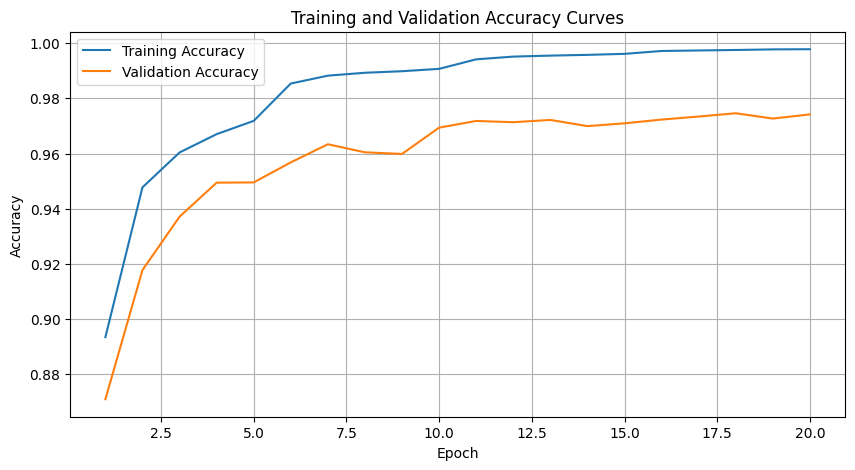

65.26480317115784
65.26480317115784
90.29144942760468
90.29144942760468
Training Took: 102.5910120566686 minutes!


In [ ]:
tracker.start()
start_time = time.time()
train_losses, val_losses, best_model_params, best_accuracy = train(model,criterion,optimizer,train_ds,val_ds, hyper_params['epochs'],lr_scheduler)
current_time = time.time()
tracker.stop()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Calculating the sparsity of the model

In [ ]:
df = pd.read_csv('emission.csv',sep =',')
df

,id,project_name,experiment_description,epoch,start_time,duration(s),power_consumption(kWh),CO2_emissions(kg),CPU_name,GPU_name,OS,region/country,cost
0,4a35a8b2-7a61-4cc4-821f-493128d72f3d,Heartbeat Classification,Training EGRU model for heartbeat classification,NaN,2024-05-07 13:13:30,6308.430942,0.246826,0.139057,"AMD EPYC 7B12/1 device(s), TDP:280.0",0 device(s),Linux,TW/Taiwan,0
1,d6fd9cd9-34e2-48ff-88df-7f35608407fc,Heartbeat Classification,Training EGRU model for heartbeat classification,NaN,2024-05-07 15:43:05,6393.503199,0.250767,0.141277,"AMD EPYC 7B12/1 device(s), TDP:280.0",0 device(s),Linux,TW/Taiwan,0
2,799407a2-f88d-4c53-bde8-88995e08483d,Heartbeat Classification,Training EGRU model for heartbeat classification,NaN,2024-05-07 17:39:10,6390.917545,0.252405,0.142200,"AMD EPYC 7B12/1 device(s), TDP:280.0",0 device(s),Linux,TW/Taiwan,0
3,b930dea0-664b-4bb7-9fbe-8399a080e386,Heartbeat Classification,Training EGRU model for heartbeat classification,NaN,2024-05-07 20:57:22,6155.628437,0.242494,0.136616,"AMD EPYC 7B12/1 device(s), TDP:280.0",0 device(s),Linux,TW/Taiwan,0


Total MACs

# Evaluation

Load the best model from training

In [ ]:
#load the best model parameters
model.load_state_dict(best_model_params)
#save the model to a file
torch.save(model.state_dict(), f'best_model{best_accuracy:.2f}.pt')


In [ ]:
#use this cell to load weights from disk
model = EGRUNetwork(input_size, hidden_size, output_size,threshold)
model.load_state_dict(torch.load('best_model0.97.pt'))

<All keys matched successfully>

Plotting the Loss

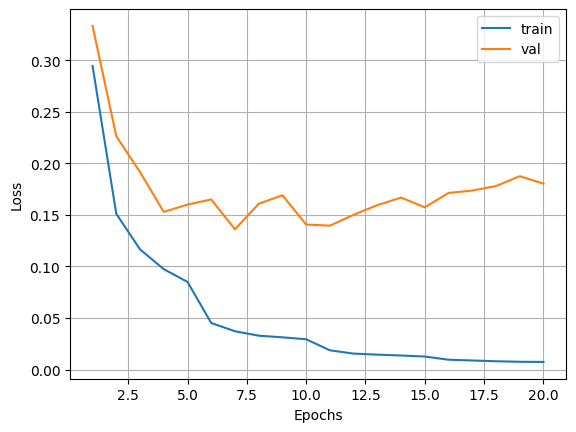

In [ ]:
#plot the training and validation losses with smooth lines
# plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
# plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.plot(range(1, len(train_losses) + 1), train_losses, label='train')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Plotting the confusion matrix

In [ ]:
#confusion matrix function
def plot_cm(model, dl, categories, normalize='true'):
    # Plot the confusion matrix
    model.eval()
    y_pred = []
    y_true = []
    for x, y in dl:
        x = x.to(device)
        y = y.to(device)
        output,_,_ = model(x)  # Output shape: (batch_size, num_classes)
        _, predicted = torch.max(output, dim=1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    y_true = torch.tensor([torch.argmax(torch.from_numpy(label)).item() for label in y_true])

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=categories.values(), yticklabels=categories.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=categories.values()))

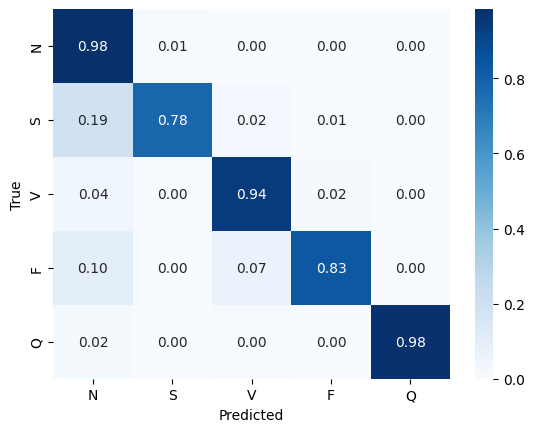

              precision    recall  f1-score   support

           N       0.99      0.98      0.99     18118
           S       0.72      0.78      0.75       556
           V       0.93      0.94      0.94      1448
           F       0.70      0.83      0.76       162
           Q       0.98      0.98      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.87      0.90      0.88     21892
weighted avg       0.98      0.97      0.97     21892



In [ ]:
class_names = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
plot_cm(model, val_ds, class_names)